In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gudhi as gd
import pickle

from sklearn.preprocessing import LabelEncoder

%matplotlib inline

#Paths 
CHALLENGE_PATH = "C:/Chazal/ChallengeIFPEN2018/"
DATA_PATH = "C:/Chazal/ChallengeIFPEN2018/challenge_fichier_dentrees_dentrainement_prediction_de_la_saturation_dhuile_residuelle/Data/"
TOOLS_PATH = "C:/Chazal/ChallengeIFPEN2018/challenge_fichier_dentrees_dentrainement_prediction_de_la_saturation_dhuile_residuelle/Tools/"

#Some constants
DEFAULT_SIZE = [175,152,152]
NB_INPUT_IMG = 400

#Home made tools for persistence features
os.chdir("C:/Seafile/Ma bibliothèque/Chazal2/MyPython36") 
from DTM import *
#from persistent_surface import *
from PdiagFeatures import *

#Classes provided with the data 
os.chdir(TOOLS_PATH)
from Image3D import Image3D
from ImageIO import ImageIO

In [84]:
from __future__ import print_function, division

import keras
from keras.layers import Convolution1D, Dense, Input, MaxPooling1D, Flatten, Dropout, Activation
from keras.models import Sequential, Model
from keras import optimizers
from keras.optimizers import SGD
from keras.optimizers import SGD,RMSprop,adam


In [3]:
#sklearn stuff
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix    
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor

In [4]:
def load_outputs(output_path=CHALLENGE_PATH):
    csv_path = os.path.join(output_path,"challenge_fichier_de_sortie_dentrainement_prediction_de_la_saturation_dhuile_residuelle.csv")
    return pd.read_csv(csv_path,sep=';')

DEFAULT_SIZE = [175,152,152]

def load_data(data_path=DATA_PATH, nb_files=400, size=DEFAULT_SIZE):
    list_img3D = []
    for nb in range(400):
        file_name = data_path + "input_" + str(nb) + ".raw"
        io = ImageIO(file_name)
        img = io.read(size[0], size[1], size[2])
        list_img3D.append(img)
    return list_img3D

def load_output_data(data_path=DATA_PATH, nb_files=400, size=DEFAULT_SIZE):
    list_out_img3D = []
    for nb in range(400):
        file_name = data_path + "output_" + str(nb) + ".raw"
        io = ImageIO(file_name)
        img = io.read(size[0], size[1], size[2])
        list_out_img3D.append(img)
    return list_out_img3D

In [5]:
outputs = load_outputs()

## 1. Load features data

### 1.1 Non persistent features

In [6]:
Feat_vol_voids = pickle.load(open(CHALLENGE_PATH + "Feat_vol_voids.dat", "rb"), encoding="latin1")
kNN=1
Feat_volDTM_voids = pickle.load(open(CHALLENGE_PATH + "Feat_volDTM"+ str(kNN) +"_voids.dat", "rb"), encoding="latin1")
Feat_area_bd = pickle.load(open(CHALLENGE_PATH + "Feat_area_bd.dat", "rb"), encoding="latin1")
Feat_vol_slices = pickle.load(open(CHALLENGE_PATH + "Voids_slices.dat", "rb"), encoding="latin1")
Feat_length_slices = pickle.load(open(CHALLENGE_PATH + "Length_slices.dat","rb"),encoding="latin1")
Feat_loc_max = pickle.load(open(CHALLENGE_PATH + "Feat_Locmax.dat", "rb"),encoding="latin1")
Feat_density_hist = pickle.load(open(CHALLENGE_PATH + "SetDensity2_hist.dat", "rb"),encoding="latin1")
#Not saved but easy and fast to compute (from cells above):
# Feat_mat

### 1.2 Persistence images (from scaled diagrams)

In [7]:
file_names = ["Feat_DTM1_scaled_","Feat_SetIntensity2_scaled_","Feat_hX_scaled_","Feat_hY_scaled_","Feat_hZ_scaled_",\
             "Feat_locmax_dist_scaled_"]

#pers_test = ["pers0_test.dat","pers1_test.dat","pers2_test.dat"]
pers_train = ["pers0.dat","pers1.dat","pers2.dat"]

pers = pers_train

Feat_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_","Feat_locmax_dist_scaled_"]
Feat_names_pers = ["pers0","pers1","pers2"]

variable_file_names=[]
for idx in range(len(file_names)):
    for jdx in range(len(pers)):
        vn = Feat_names[idx] + Feat_names_pers[jdx]
        fn = file_names[idx] + pers[jdx]
        variable_file_names.append([vn,fn])
            
#Create the variables            
dct = dict()
for vn in variable_file_names:
    dct[vn[0]] = []
for k,v in dct.items():
    exec("%s=%s" % (k,v))

v = locals()
for vn in variable_file_names:
    file_name = vn[1]
    v[vn[0]] = pickle.load(open(CHALLENGE_PATH+file_name, "rb"), encoding="latin1") 

### 1.3 Min-max birth-death

In [8]:
file_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_",\
             "Feat_locmax_dist_"]

bd_test = ["bd0_test.dat","bd1_test.dat","bd2_test.dat"]
bd_train = ["bd0.dat","bd1.dat","bd2.dat"]

#if TrainTest == "Train":
bd = bd_train
#else:
#    bd = bd_test

Feat_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_","Feat_locmax_dist_"]
Feat_names_bd = ["bd0","bd1","bd2"]

variable_file_names=[]
for idx in range(len(file_names)):
    for jdx in range(len(bd)):
        vn = Feat_names[idx] + Feat_names_bd[jdx]
        fn = file_names[idx] + bd[jdx]
        variable_file_names.append([vn,fn])
            
#Create the variables            
dct = dict()
for vn in variable_file_names:
    dct[vn[0]] = []
for k,v in dct.items():
    exec("%s=%s" % (k,v))

list_Feat_bd = []
v = locals()
for vn in variable_file_names:
    file_name = vn[1]
    v[vn[0]] = pickle.load(open(CHALLENGE_PATH+file_name, "rb"), encoding="latin1") 
    list_Feat_bd.append(v[vn[0]])

Feat_bd = np.concatenate(list_Feat_bd,axis=1)
#print(np.shape(Feat_bd))

### 1.4 Entropy curves

In [14]:
file_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_",\
             "Feat_locmax_dist_"]

ent_test = ["ent0_test.dat","ent1_test.dat","ent2_test.dat"]
ent_train = ["ent0.dat","ent1.dat","ent2.dat"]

#if TrainTest == "Train":
ent = ent_train
#else:
#    ent = ent_test

Feat_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_","Feat_locmax_dist_"]
Feat_names_ent = ["ent0","ent1","ent2"]

variable_file_names=[]
for idx in range(len(file_names)):
    for jdx in range(len(bd)):
        vn = Feat_names[idx] + Feat_names_ent[jdx]
        fn = file_names[idx] + ent[jdx]
        variable_file_names.append([vn,fn])
            
#Create the variables            
dct = dict()
for vn in variable_file_names:
    dct[vn[0]] = []
for k,v in dct.items():
    exec("%s=%s" % (k,v))

list_Feat_ent = []
v = locals()
for vn in variable_file_names:
    file_name = vn[1]
    v[vn[0]] = pickle.load(open(CHALLENGE_PATH+file_name, "rb"), encoding="latin1") 
    list_Feat_ent.append(v[vn[0]])
Feat_ent = np.concatenate(list_Feat_ent,axis=1)

### 1.4bis Betti curves

In [18]:
file_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_",\
             "Feat_locmax_dist_","Feat_skel_"]

betti_test = ["bet_cv0_test.dat","bet_cv1_test.dat","bet_cv2_test.dat"]
betti_train = ["bet_cv0.dat","bet_cv1.dat","bet_cv2.dat"]

#if TrainTest == "Train":
betti = betti_train
#else:
#    betti = betti_test

Feat_names = ["Feat_DTM1_","Feat_SetIntensity2_","Feat_hX_","Feat_hY_","Feat_hZ_","Feat_locmax_dist_","Feat_skel_"]
Feat_names_ent = ["bet_cv0","bet_cv1","bet_cv2"]

variable_file_names=[]
for idx in range(len(file_names)):
    for jdx in range(len(betti)):
        vn = Feat_names[idx] + Feat_names_ent[jdx]
        fn = file_names[idx] + betti[jdx]
        variable_file_names.append([vn,fn])
            
#Create the variables            
dct = dict()
for vn in variable_file_names:
    dct[vn[0]] = []
for k,v in dct.items():
    exec("%s=%s" % (k,v))

list_Feat_bet = []
v = locals()
for vn in variable_file_names:
    file_name = vn[1]
    v[vn[0]] = pickle.load(open(CHALLENGE_PATH+file_name, "rb"), encoding="latin1") 
    list_Feat_bet.append(v[vn[0]])
Feat_bet = np.concatenate(list_Feat_bet,axis=1)

print(np.shape(Feat_bet))

(400, 1260)


In [19]:
encoder = LabelEncoder()
material_cat = outputs["material"]
Feat_mat = encoder.fit_transform(material_cat)
Feat_mat = np.reshape(Feat_mat,(400,1))

### 1.5 Concatenate features

In [111]:
Feat_vol_voids = np.reshape(Feat_vol_voids,(NB_INPUT_IMG,1))
Feat_volDTM_voids = np.reshape(Feat_volDTM_voids,(NB_INPUT_IMG,1))

#Feat_mat: encode material. WARNING! This is not a real feature, it needs to be predicted first.  


#Feat_bd has been defined while laoding all the min_max birth_death above. 
#Feat_ent has been defined while loading all the entropy features above

#Subselect some of the Entropy curves: 
nb_x_steps = 20
Feat_ent_DTM1 = Feat_ent[:,0:3*nb_x_steps]
Feat_ent_Intensity2 = Feat_ent[:,3*nb_x_steps:6*nb_x_steps]
Feat_ent_hX = Feat_ent[:,6*nb_x_steps:9*nb_x_steps]
Feat_ent_hY = Feat_ent[:,9*nb_x_steps:12*nb_x_steps]
Feat_ent_hZ = Feat_ent[:,12*nb_x_steps:15*nb_x_steps]
Feat_ent_locmax_dist = Feat_ent[:,15*nb_x_steps:18*nb_x_steps]

#subselect some of the betti curves
nb_x_steps = 60
Feat_bet_DTM1 = Feat_bet[:,0:3*nb_x_steps]
Feat_bet_Intensity2 = Feat_bet[:,3*nb_x_steps:6*nb_x_steps]
Feat_bet_hX = Feat_bet[:,6*nb_x_steps:9*nb_x_steps]
Feat_bet_hY = Feat_bet[:,9*nb_x_steps:12*nb_x_steps]
Feat_bet_hZ = Feat_bet[:,12*nb_x_steps:15*nb_x_steps]
Feat_bet_locmax_dist = Feat_bet[:,15*nb_x_steps:18*nb_x_steps]
Feat_bet_skel = Feat_bet[:,18*nb_x_steps:21*nb_x_steps]



Feat_density = Feat_density_hist
Feat_slices = np.concatenate([Feat_vol_slices,Feat_length_slices],axis=1)
Feat_Voids = np.concatenate([Feat_vol_voids,Feat_volDTM_voids,Feat_area_bd],axis=1)
#Feat_DTM30_pers = np.concatenate([Feat_DTM30_pers0,Feat_DTM30_pers1,Feat_DTM30_pers2],axis=1)
Feat_DTM1_pers = np.concatenate([Feat_DTM1_pers0,Feat_DTM1_pers1,Feat_DTM1_pers2],axis=1)
#Feat_locmax_pers = np.concatenate([Feat_locmax_pers0,Feat_locmax_pers1,Feat_locmax_pers2],axis=1)
#Feat_locmax_dist_pers = np.concatenate([Feat_locmax_dist_pers0,Feat_locmax_dist_pers1,Feat_locmax_dist_pers2],axis=1)
Feat_SetIntensity2_pers = np.concatenate([Feat_SetIntensity2_pers0,Feat_SetIntensity2_pers1,Feat_SetIntensity2_pers2],axis=1)
Feat_hX_pers =np.concatenate([Feat_hX_pers0,Feat_hX_pers1,Feat_hX_pers2],axis=1)
Feat_hY_pers =np.concatenate([Feat_hY_pers0,Feat_hY_pers1,Feat_hY_pers2],axis=1)
Feat_hZ_pers =np.concatenate([Feat_hZ_pers0,Feat_hZ_pers1,Feat_hZ_pers2],axis=1)

In [121]:
nb_x_steps = 60

TS_input = Feat_bet[:,0:6*nb_x_steps] #DTM1 and intensity
TS_input = np.reshape(TS_input,(np.shape(TS_input)[0],nb_x_steps,-1))

print(np.shape(TS_input))

Feat = np.concatenate([Feat_mat,Feat_Voids,Feat_loc_max,Feat_density, Feat_bd],axis=1)
print(np.shape(Feat))

(400, 60, 6)
(400, 127)


In [122]:
TS_train, TS_test, Feat_train, Feat_test, y_train, y_test = train_test_split(TS_input, Feat, outputs["sor"], test_size = 0.2)

#### Input data normalization

In [123]:
for i in range(6):
    print(np.min(TS_input[:,:,i]), " - ", np.max(TS_input[:,:,i]))

0.0  -  2375.0
0.0  -  2070.0
0.0  -  2365.0
0.0  -  2348.0
0.0  -  2319.0
0.0  -  2539.0


In [124]:
TS_input = TS_input/2500

scaler = MinMaxScaler()
scaler.fit(Feat_train)
Feat_train = scaler.transform(Feat_train)
Feat_test = scaler.transform(Feat_test)

### Simple 1D CNN taking only betti curves

In [98]:
nb_filter = 32
kernel_length = 6
window_size = np.shape(TS_input)[1]
nb_input_series = np.shape(TS_input)[2]
nb_outputs = 1

model = Sequential((
        # The first conv layer learns `nb_filter` filters (aka kernels), each of size ``(filter_length, nb_input_series)``.
        # Its output will have shape (None, window_size - filter_length + 1, nb_filter), i.e., for each position in
        # the input timeseries, the activation of each filter at that position.
        Convolution1D(activation='relu', input_shape=(window_size, nb_input_series),\
                      filters=nb_filter, kernel_size=kernel_length),
        MaxPooling1D(),     # Downsample the output of convolution by 2X.
        Dropout(0.5),
        Convolution1D(activation='relu',filters=nb_filter, kernel_size=kernel_length),
        MaxPooling1D(),
        Dropout(0.5),
        Flatten(),
        #keras.layers.BatchNormalization(),
        Dense(nb_outputs, activation='linear'),     # For binary classification, change the activation to 'sigmoid'
    ))

#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])  #optimizer='adam'

In [141]:
num_epoch = 500
hist = model.fit(TS_train, y_train, nb_epoch=num_epoch, batch_size=80, validation_data=(TS_test, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[[  1.,   1.,   1.,   2.,   2.,   2.],
        [  3.,   3.,   4.,   5.,   5.,   8.],
        [ 10.,  10.,  21.,  25.,  25.,  28.],
        ...,
        [270., 279., 295., 296., 309., 323.],
  ...

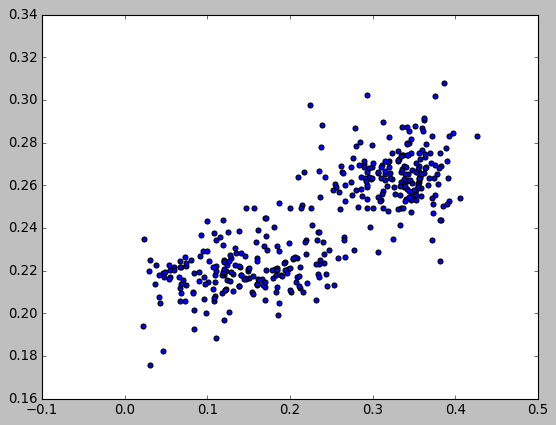

In [108]:
plt.scatter(y_train,model.predict(TS_train))
plt.scatter(y_test,model.predict(TS_test))

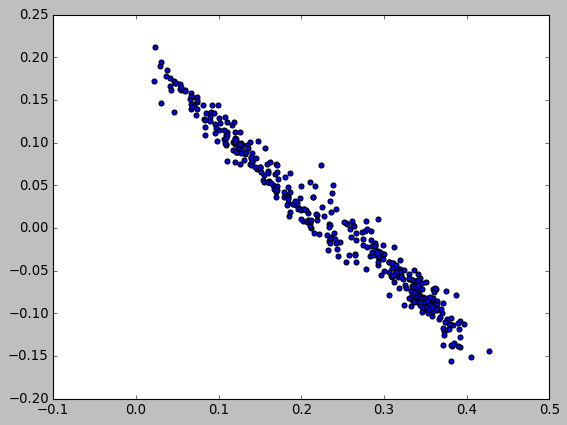

In [109]:
plt.scatter(y_train,np.ravel(model.predict(TS_train))-y_train)
plt.scatter(y_test,np.ravel(model.predict(TS_test))-y_test)

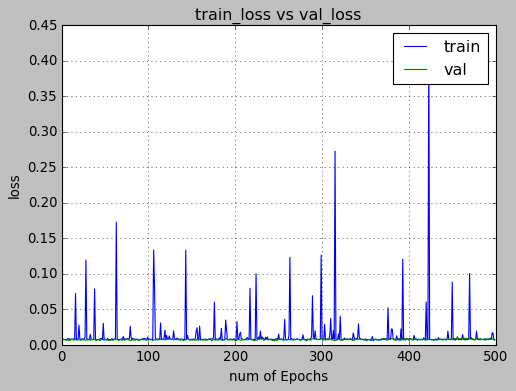

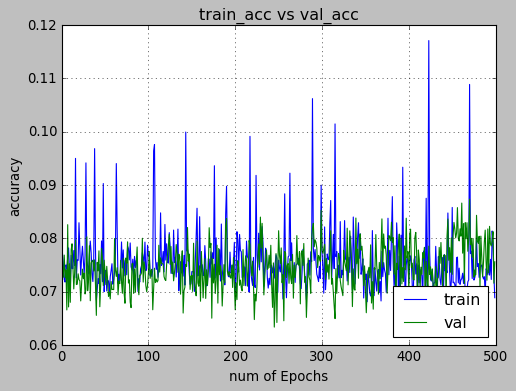

In [110]:
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['mean_absolute_error']
val_acc=hist.history['val_mean_absolute_error']
xc=range(num_epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

### Model taking entropy curves for 1D CNN + features in a dense network

In [129]:
nb_filter = 32
kernel_length = 6
window_size = np.shape(TS_input)[1]
nb_input_series = np.shape(TS_input)[2]
nb_outputs_1 = 32

input_1 = Input(shape=(window_size, nb_input_series), dtype='float32', name='input_1')
output_1 = Convolution1D(activation='relu', filters=nb_filter, kernel_size=kernel_length)(input_1)
output_1 = MaxPooling1D()(output_1)
output_1 = Dropout(0.5)(output_1)
output_1 = Flatten()(output_1)
output_1 = Dense(nb_outputs_1, activation='linear',name='output_1')(output_1)

input_2 = Input(shape=(np.shape(Feat)[1],),dtype='float32', name='input_2')
output_2 = keras.layers.normalization.BatchNormalization()(input_2)
#output_2 = Dense(256, activation='relu')(output_2)
output_2 = Dense(64, activation='relu')(output_2)
output_2 = Dropout(0.5)(output_2)
output_2 = Dense(32,activation='relu', name='output_2')(output_2)

x = keras.layers.concatenate([output_1,output_2])
x = keras.layers.normalization.BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5, noise_shape=None, seed=None)(x)
x = Dense(64, activation='relu')(x)
#x = Dropout(0.3, noise_shape=None, seed=None)(x)
x = keras.layers.normalization.BatchNormalization()(x)

output = Dense(1, activation='linear')(x)

model = Model(inputs=[input_1, input_2], outputs=[output])
model.compile(optimizer='rmsprop', loss='mse',
              metrics=['mae'])

In [171]:
num_epoch = 1500
model.fit([TS_train, Feat_train], [y_train], nb_epoch=num_epoch, batch_size=320, validation_data=([TS_test,Feat_test], [y_test]))

Train on 320 samples, validate on 80 samples
Epoch 1/1500
320/320 [==============================] - 0s 70us/step - loss: 6.2807e-04 - mean_absolute_error: 0.0149 - val_loss: 0.0026 - val_mean_absolute_error: 0.0414
Epoch 2/1500
320/320 [==============================] - 0s 67us/step - loss: 6.3676e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0034 - val_mean_absolute_error: 0.0461
Epoch 3/1500
320/320 [==============================] - 0s 70us/step - loss: 6.0512e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0025 - val_mean_absolute_error: 0.0403
Epoch 4/1500
320/320 [==============================] - 0s 70us/step - loss: 4.0970e-04 - mean_absolute_error: 0.0128 - val_loss: 0.0031 - val_mean_absolute_error: 0.0444
Epoch 5/1500
320/320 [==============================] - 0s 67us/step - loss: 4.4528e-04 - mean_absolute_error: 0.0136 - val_loss: 0.0026 - val_mean_absolute_error: 0.0413
Epoch 6/1500
320/320 [==============================] - 0s 69us/step - loss: 3.4444e-04 - mean_absol

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 9/1500
320/320 [==============================] - 0s 74us/step - loss: 3.9614e-04 - mean_absolute_error: 0.0121 - val_loss: 0.0026 - val_mean_absolute_error: 0.0410
Epoch 10/1500
320/320 [==============================] - 0s 80us/step - loss: 3.9469e-04 - mean_absolute_error: 0.0127 - val_loss: 0.0033 - val_mean_absolute_error: 0.0454
Epoch 11/1500
320/320 [==============================] - 0s 78us/step - loss: 4.0300e-04 - mean_absolute_error: 0.0130 - val_loss: 0.0027 - val_mean_absolute_error: 0.0415
Epoch 12/1500
320/320 [==============================] - 0s 75us/step - loss: 3.5324e-04 - mean_absolute_error: 0.0123 - val_loss: 0.0032 - val_mean_absolute_error: 0.0447
Epoch 13/1500
320/320 [==============================] - 0s 72us/step - loss: 4.0129e-04 - mean_absolute_error: 0.0129 - val_loss: 0.0027 - val_mean_absolute_error: 0.0417
Epoch 14/1500
320/320 [==============================] - 0s 74us/step - loss: 4.5988e-04 - mean_absolute_error: 0.0137 - val_loss: 0.0033 - v

Epoch 57/1500
320/320 [==============================] - 0s 67us/step - loss: 4.6379e-04 - mean_absolute_error: 0.0136 - val_loss: 0.0027 - val_mean_absolute_error: 0.0417
Epoch 58/1500
320/320 [==============================] - 0s 83us/step - loss: 6.1911e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0031 - val_mean_absolute_error: 0.0427
Epoch 59/1500
320/320 [==============================] - 0s 78us/step - loss: 7.1366e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0029 - val_mean_absolute_error: 0.0429
Epoch 60/1500
320/320 [==============================] - 0s 69us/step - loss: 6.1739e-04 - mean_absolute_error: 0.0143 - val_loss: 0.0029 - val_mean_absolute_error: 0.0426
Epoch 61/1500
320/320 [==============================] - 0s 69us/step - loss: 4.2637e-04 - mean_absolute_error: 0.0130 - val_loss: 0.0027 - val_mean_absolute_error: 0.0410
Epoch 62/1500
320/320 [==============================] - 0s 69us/step - loss: 3.7737e-04 - mean_absolute_error: 0.0122 - val_loss: 0.0028 - 

Epoch 105/1500
320/320 [==============================] - 0s 72us/step - loss: 3.9167e-04 - mean_absolute_error: 0.0126 - val_loss: 0.0028 - val_mean_absolute_error: 0.0419
Epoch 106/1500
320/320 [==============================] - 0s 72us/step - loss: 3.0629e-04 - mean_absolute_error: 0.0117 - val_loss: 0.0029 - val_mean_absolute_error: 0.0423
Epoch 107/1500
320/320 [==============================] - 0s 70us/step - loss: 2.3701e-04 - mean_absolute_error: 0.0105 - val_loss: 0.0027 - val_mean_absolute_error: 0.0411
Epoch 108/1500
320/320 [==============================] - 0s 75us/step - loss: 2.2326e-04 - mean_absolute_error: 0.0101 - val_loss: 0.0028 - val_mean_absolute_error: 0.0425
Epoch 109/1500
320/320 [==============================] - 0s 72us/step - loss: 1.6408e-04 - mean_absolute_error: 0.0094 - val_loss: 0.0027 - val_mean_absolute_error: 0.0412
Epoch 110/1500
320/320 [==============================] - 0s 75us/step - loss: 1.7901e-04 - mean_absolute_error: 0.0094 - val_loss: 0.0

Epoch 153/1500
320/320 [==============================] - 0s 67us/step - loss: 2.0082e-04 - mean_absolute_error: 0.0092 - val_loss: 0.0027 - val_mean_absolute_error: 0.0423
Epoch 154/1500
320/320 [==============================] - 0s 66us/step - loss: 2.2211e-04 - mean_absolute_error: 0.0098 - val_loss: 0.0028 - val_mean_absolute_error: 0.0422
Epoch 155/1500
320/320 [==============================] - 0s 64us/step - loss: 2.6000e-04 - mean_absolute_error: 0.0102 - val_loss: 0.0027 - val_mean_absolute_error: 0.0421
Epoch 156/1500
320/320 [==============================] - 0s 63us/step - loss: 2.5617e-04 - mean_absolute_error: 0.0100 - val_loss: 0.0029 - val_mean_absolute_error: 0.0426
Epoch 157/1500
320/320 [==============================] - 0s 64us/step - loss: 3.6588e-04 - mean_absolute_error: 0.0113 - val_loss: 0.0029 - val_mean_absolute_error: 0.0442
Epoch 158/1500
320/320 [==============================] - 0s 61us/step - loss: 7.6894e-04 - mean_absolute_error: 0.0145 - val_loss: 0.0

Epoch 201/1500
320/320 [==============================] - 0s 67us/step - loss: 9.1485e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0030 - val_mean_absolute_error: 0.0436
Epoch 202/1500
320/320 [==============================] - 0s 72us/step - loss: 9.2171e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0037 - val_mean_absolute_error: 0.0460
Epoch 203/1500
320/320 [==============================] - 0s 64us/step - loss: 9.4088e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0030 - val_mean_absolute_error: 0.0439
Epoch 204/1500
320/320 [==============================] - 0s 64us/step - loss: 6.1649e-04 - mean_absolute_error: 0.0125 - val_loss: 0.0031 - val_mean_absolute_error: 0.0436
Epoch 205/1500
320/320 [==============================] - 0s 63us/step - loss: 4.0660e-04 - mean_absolute_error: 0.0114 - val_loss: 0.0028 - val_mean_absolute_error: 0.0424
Epoch 206/1500
320/320 [==============================] - 0s 61us/step - loss: 3.8704e-04 - mean_absolute_error: 0.0112 - val_loss: 0.0

Epoch 249/1500
320/320 [==============================] - 0s 66us/step - loss: 2.8037e-04 - mean_absolute_error: 0.0102 - val_loss: 0.0030 - val_mean_absolute_error: 0.0447
Epoch 250/1500
320/320 [==============================] - 0s 69us/step - loss: 2.7441e-04 - mean_absolute_error: 0.0102 - val_loss: 0.0029 - val_mean_absolute_error: 0.0428
Epoch 251/1500
320/320 [==============================] - 0s 66us/step - loss: 2.8626e-04 - mean_absolute_error: 0.0096 - val_loss: 0.0030 - val_mean_absolute_error: 0.0441
Epoch 252/1500
320/320 [==============================] - 0s 66us/step - loss: 3.8603e-04 - mean_absolute_error: 0.0111 - val_loss: 0.0030 - val_mean_absolute_error: 0.0428
Epoch 253/1500
320/320 [==============================] - 0s 64us/step - loss: 4.1590e-04 - mean_absolute_error: 0.0111 - val_loss: 0.0032 - val_mean_absolute_error: 0.0455
Epoch 254/1500
320/320 [==============================] - 0s 66us/step - loss: 6.2936e-04 - mean_absolute_error: 0.0138 - val_loss: 0.0

Epoch 297/1500
320/320 [==============================] - 0s 72us/step - loss: 2.2648e-04 - mean_absolute_error: 0.0103 - val_loss: 0.0027 - val_mean_absolute_error: 0.0409
Epoch 298/1500
320/320 [==============================] - 0s 67us/step - loss: 2.2506e-04 - mean_absolute_error: 0.0103 - val_loss: 0.0029 - val_mean_absolute_error: 0.0434
Epoch 299/1500
320/320 [==============================] - 0s 66us/step - loss: 3.6855e-04 - mean_absolute_error: 0.0131 - val_loss: 0.0028 - val_mean_absolute_error: 0.0420
Epoch 300/1500
320/320 [==============================] - 0s 63us/step - loss: 4.0216e-04 - mean_absolute_error: 0.0133 - val_loss: 0.0030 - val_mean_absolute_error: 0.0446
Epoch 301/1500
320/320 [==============================] - 0s 64us/step - loss: 4.1778e-04 - mean_absolute_error: 0.0133 - val_loss: 0.0029 - val_mean_absolute_error: 0.0429
Epoch 302/1500
320/320 [==============================] - 0s 64us/step - loss: 5.7045e-04 - mean_absolute_error: 0.0136 - val_loss: 0.0

Epoch 345/1500
320/320 [==============================] - 0s 69us/step - loss: 5.2206e-04 - mean_absolute_error: 0.0137 - val_loss: 0.0029 - val_mean_absolute_error: 0.0424
Epoch 346/1500
320/320 [==============================] - 0s 69us/step - loss: 4.7750e-04 - mean_absolute_error: 0.0138 - val_loss: 0.0029 - val_mean_absolute_error: 0.0435
Epoch 347/1500
320/320 [==============================] - 0s 71us/step - loss: 3.9934e-04 - mean_absolute_error: 0.0128 - val_loss: 0.0029 - val_mean_absolute_error: 0.0430
Epoch 348/1500
320/320 [==============================] - 0s 69us/step - loss: 3.5098e-04 - mean_absolute_error: 0.0123 - val_loss: 0.0029 - val_mean_absolute_error: 0.0431
Epoch 349/1500
320/320 [==============================] - 0s 78us/step - loss: 3.7150e-04 - mean_absolute_error: 0.0125 - val_loss: 0.0028 - val_mean_absolute_error: 0.0417
Epoch 350/1500
320/320 [==============================] - 0s 72us/step - loss: 3.2681e-04 - mean_absolute_error: 0.0119 - val_loss: 0.0

Epoch 393/1500
320/320 [==============================] - 0s 69us/step - loss: 3.8537e-04 - mean_absolute_error: 0.0124 - val_loss: 0.0028 - val_mean_absolute_error: 0.0421
Epoch 394/1500
320/320 [==============================] - 0s 80us/step - loss: 3.7422e-04 - mean_absolute_error: 0.0126 - val_loss: 0.0029 - val_mean_absolute_error: 0.0433
Epoch 395/1500
320/320 [==============================] - 0s 69us/step - loss: 4.0952e-04 - mean_absolute_error: 0.0137 - val_loss: 0.0029 - val_mean_absolute_error: 0.0433
Epoch 396/1500
320/320 [==============================] - 0s 77us/step - loss: 3.4892e-04 - mean_absolute_error: 0.0128 - val_loss: 0.0029 - val_mean_absolute_error: 0.0428
Epoch 397/1500
320/320 [==============================] - 0s 72us/step - loss: 2.5294e-04 - mean_absolute_error: 0.0110 - val_loss: 0.0029 - val_mean_absolute_error: 0.0429
Epoch 398/1500
320/320 [==============================] - 0s 67us/step - loss: 3.2073e-04 - mean_absolute_error: 0.0115 - val_loss: 0.0

Epoch 441/1500
320/320 [==============================] - 0s 67us/step - loss: 8.9623e-04 - mean_absolute_error: 0.0168 - val_loss: 0.0029 - val_mean_absolute_error: 0.0427
Epoch 442/1500
320/320 [==============================] - 0s 67us/step - loss: 7.3166e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0032 - val_mean_absolute_error: 0.0450
Epoch 443/1500
320/320 [==============================] - 0s 66us/step - loss: 5.6932e-04 - mean_absolute_error: 0.0144 - val_loss: 0.0028 - val_mean_absolute_error: 0.0422
Epoch 444/1500
320/320 [==============================] - 0s 66us/step - loss: 4.3435e-04 - mean_absolute_error: 0.0133 - val_loss: 0.0030 - val_mean_absolute_error: 0.0436
Epoch 445/1500
320/320 [==============================] - 0s 64us/step - loss: 2.7193e-04 - mean_absolute_error: 0.0113 - val_loss: 0.0028 - val_mean_absolute_error: 0.0418
Epoch 446/1500
320/320 [==============================] - 0s 64us/step - loss: 3.2017e-04 - mean_absolute_error: 0.0124 - val_loss: 0.0

Epoch 489/1500
320/320 [==============================] - 0s 71us/step - loss: 8.0151e-04 - mean_absolute_error: 0.0166 - val_loss: 0.0028 - val_mean_absolute_error: 0.0423
Epoch 490/1500
320/320 [==============================] - 0s 75us/step - loss: 5.3867e-04 - mean_absolute_error: 0.0138 - val_loss: 0.0030 - val_mean_absolute_error: 0.0435
Epoch 491/1500
320/320 [==============================] - 0s 70us/step - loss: 5.0895e-04 - mean_absolute_error: 0.0142 - val_loss: 0.0029 - val_mean_absolute_error: 0.0426
Epoch 492/1500
320/320 [==============================] - 0s 67us/step - loss: 4.2551e-04 - mean_absolute_error: 0.0135 - val_loss: 0.0029 - val_mean_absolute_error: 0.0424
Epoch 493/1500
320/320 [==============================] - 0s 77us/step - loss: 3.2927e-04 - mean_absolute_error: 0.0125 - val_loss: 0.0027 - val_mean_absolute_error: 0.0418
Epoch 494/1500
320/320 [==============================] - 0s 74us/step - loss: 3.0291e-04 - mean_absolute_error: 0.0124 - val_loss: 0.0

Epoch 537/1500
320/320 [==============================] - 0s 72us/step - loss: 3.3075e-04 - mean_absolute_error: 0.0118 - val_loss: 0.0028 - val_mean_absolute_error: 0.0421
Epoch 538/1500
320/320 [==============================] - 0s 66us/step - loss: 3.2055e-04 - mean_absolute_error: 0.0123 - val_loss: 0.0030 - val_mean_absolute_error: 0.0432
Epoch 539/1500
320/320 [==============================] - 0s 69us/step - loss: 3.6635e-04 - mean_absolute_error: 0.0137 - val_loss: 0.0029 - val_mean_absolute_error: 0.0430
Epoch 540/1500
320/320 [==============================] - 0s 66us/step - loss: 4.4952e-04 - mean_absolute_error: 0.0144 - val_loss: 0.0030 - val_mean_absolute_error: 0.0438
Epoch 541/1500
320/320 [==============================] - 0s 69us/step - loss: 4.9031e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0029 - val_mean_absolute_error: 0.0431
Epoch 542/1500
320/320 [==============================] - 0s 64us/step - loss: 4.5294e-04 - mean_absolute_error: 0.0133 - val_loss: 0.0

Epoch 585/1500
320/320 [==============================] - 0s 66us/step - loss: 6.6779e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0031 - val_mean_absolute_error: 0.0446
Epoch 586/1500
320/320 [==============================] - 0s 69us/step - loss: 7.3545e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0032 - val_mean_absolute_error: 0.0448
Epoch 587/1500
320/320 [==============================] - 0s 63us/step - loss: 6.8444e-04 - mean_absolute_error: 0.0171 - val_loss: 0.0030 - val_mean_absolute_error: 0.0439
Epoch 588/1500
320/320 [==============================] - 0s 66us/step - loss: 5.3167e-04 - mean_absolute_error: 0.0146 - val_loss: 0.0030 - val_mean_absolute_error: 0.0443
Epoch 589/1500
320/320 [==============================] - 0s 69us/step - loss: 4.1767e-04 - mean_absolute_error: 0.0139 - val_loss: 0.0028 - val_mean_absolute_error: 0.0425
Epoch 590/1500
320/320 [==============================] - 0s 64us/step - loss: 3.7601e-04 - mean_absolute_error: 0.0118 - val_loss: 0.0

Epoch 633/1500
320/320 [==============================] - 0s 64us/step - loss: 3.4734e-04 - mean_absolute_error: 0.0128 - val_loss: 0.0029 - val_mean_absolute_error: 0.0427
Epoch 634/1500
320/320 [==============================] - 0s 63us/step - loss: 3.7975e-04 - mean_absolute_error: 0.0123 - val_loss: 0.0032 - val_mean_absolute_error: 0.0447
Epoch 635/1500
320/320 [==============================] - 0s 66us/step - loss: 5.3527e-04 - mean_absolute_error: 0.0139 - val_loss: 0.0028 - val_mean_absolute_error: 0.0421
Epoch 636/1500
320/320 [==============================] - 0s 64us/step - loss: 6.6757e-04 - mean_absolute_error: 0.0154 - val_loss: 0.0034 - val_mean_absolute_error: 0.0458
Epoch 637/1500
320/320 [==============================] - 0s 67us/step - loss: 6.8397e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0028 - val_mean_absolute_error: 0.0417
Epoch 638/1500
320/320 [==============================] - 0s 64us/step - loss: 5.7354e-04 - mean_absolute_error: 0.0136 - val_loss: 0.0

Epoch 681/1500
320/320 [==============================] - 0s 70us/step - loss: 6.1835e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0030 - val_mean_absolute_error: 0.0433
Epoch 682/1500
320/320 [==============================] - 0s 67us/step - loss: 6.2802e-04 - mean_absolute_error: 0.0143 - val_loss: 0.0031 - val_mean_absolute_error: 0.0445
Epoch 683/1500
320/320 [==============================] - 0s 64us/step - loss: 4.9236e-04 - mean_absolute_error: 0.0136 - val_loss: 0.0029 - val_mean_absolute_error: 0.0426
Epoch 684/1500
320/320 [==============================] - 0s 63us/step - loss: 4.3832e-04 - mean_absolute_error: 0.0128 - val_loss: 0.0031 - val_mean_absolute_error: 0.0448
Epoch 685/1500
320/320 [==============================] - 0s 64us/step - loss: 4.1454e-04 - mean_absolute_error: 0.0129 - val_loss: 0.0028 - val_mean_absolute_error: 0.0418
Epoch 686/1500
320/320 [==============================] - 0s 63us/step - loss: 4.0068e-04 - mean_absolute_error: 0.0134 - val_loss: 0.0

Epoch 729/1500
320/320 [==============================] - 0s 69us/step - loss: 3.8512e-04 - mean_absolute_error: 0.0109 - val_loss: 0.0030 - val_mean_absolute_error: 0.0429
Epoch 730/1500
320/320 [==============================] - 0s 66us/step - loss: 4.5571e-04 - mean_absolute_error: 0.0120 - val_loss: 0.0030 - val_mean_absolute_error: 0.0433
Epoch 731/1500
320/320 [==============================] - 0s 69us/step - loss: 4.4298e-04 - mean_absolute_error: 0.0119 - val_loss: 0.0029 - val_mean_absolute_error: 0.0417
Epoch 732/1500
320/320 [==============================] - 0s 77us/step - loss: 6.0228e-04 - mean_absolute_error: 0.0132 - val_loss: 0.0033 - val_mean_absolute_error: 0.0455
Epoch 733/1500
320/320 [==============================] - 0s 70us/step - loss: 6.5558e-04 - mean_absolute_error: 0.0133 - val_loss: 0.0030 - val_mean_absolute_error: 0.0427
Epoch 734/1500
320/320 [==============================] - 0s 77us/step - loss: 6.1783e-04 - mean_absolute_error: 0.0129 - val_loss: 0.0

Epoch 777/1500
320/320 [==============================] - 0s 67us/step - loss: 8.9742e-04 - mean_absolute_error: 0.0143 - val_loss: 0.0032 - val_mean_absolute_error: 0.0438
Epoch 778/1500
320/320 [==============================] - 0s 75us/step - loss: 7.6725e-04 - mean_absolute_error: 0.0135 - val_loss: 0.0032 - val_mean_absolute_error: 0.0452
Epoch 779/1500
320/320 [==============================] - 0s 64us/step - loss: 5.9820e-04 - mean_absolute_error: 0.0130 - val_loss: 0.0029 - val_mean_absolute_error: 0.0424
Epoch 780/1500
320/320 [==============================] - 0s 64us/step - loss: 4.0455e-04 - mean_absolute_error: 0.0118 - val_loss: 0.0028 - val_mean_absolute_error: 0.0422
Epoch 781/1500
320/320 [==============================] - 0s 64us/step - loss: 3.7106e-04 - mean_absolute_error: 0.0116 - val_loss: 0.0028 - val_mean_absolute_error: 0.0411
Epoch 782/1500
320/320 [==============================] - 0s 64us/step - loss: 3.7298e-04 - mean_absolute_error: 0.0109 - val_loss: 0.0

Epoch 825/1500
320/320 [==============================] - 0s 81us/step - loss: 4.2875e-04 - mean_absolute_error: 0.0119 - val_loss: 0.0029 - val_mean_absolute_error: 0.0421
Epoch 826/1500
320/320 [==============================] - 0s 75us/step - loss: 5.3221e-04 - mean_absolute_error: 0.0128 - val_loss: 0.0028 - val_mean_absolute_error: 0.0422
Epoch 827/1500
320/320 [==============================] - 0s 75us/step - loss: 5.8249e-04 - mean_absolute_error: 0.0125 - val_loss: 0.0030 - val_mean_absolute_error: 0.0425
Epoch 828/1500
320/320 [==============================] - 0s 75us/step - loss: 6.4406e-04 - mean_absolute_error: 0.0130 - val_loss: 0.0029 - val_mean_absolute_error: 0.0431
Epoch 829/1500
320/320 [==============================] - 0s 70us/step - loss: 7.5459e-04 - mean_absolute_error: 0.0145 - val_loss: 0.0032 - val_mean_absolute_error: 0.0436
Epoch 830/1500
320/320 [==============================] - 0s 74us/step - loss: 7.5288e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0

Epoch 873/1500
320/320 [==============================] - 0s 72us/step - loss: 0.0013 - mean_absolute_error: 0.0168 - val_loss: 0.0038 - val_mean_absolute_error: 0.0464
Epoch 874/1500
320/320 [==============================] - 0s 80us/step - loss: 0.0013 - mean_absolute_error: 0.0170 - val_loss: 0.0034 - val_mean_absolute_error: 0.0460
Epoch 875/1500
320/320 [==============================] - 0s 78us/step - loss: 9.0496e-04 - mean_absolute_error: 0.0144 - val_loss: 0.0031 - val_mean_absolute_error: 0.0436
Epoch 876/1500
320/320 [==============================] - 0s 69us/step - loss: 5.0170e-04 - mean_absolute_error: 0.0117 - val_loss: 0.0028 - val_mean_absolute_error: 0.0432
Epoch 877/1500
320/320 [==============================] - 0s 67us/step - loss: 3.2505e-04 - mean_absolute_error: 0.0107 - val_loss: 0.0028 - val_mean_absolute_error: 0.0421
Epoch 878/1500
320/320 [==============================] - 0s 66us/step - loss: 2.3055e-04 - mean_absolute_error: 0.0097 - val_loss: 0.0026 - va

Epoch 921/1500
320/320 [==============================] - 0s 70us/step - loss: 3.1035e-04 - mean_absolute_error: 0.0105 - val_loss: 0.0027 - val_mean_absolute_error: 0.0413
Epoch 922/1500
320/320 [==============================] - 0s 67us/step - loss: 2.9147e-04 - mean_absolute_error: 0.0101 - val_loss: 0.0027 - val_mean_absolute_error: 0.0412
Epoch 923/1500
320/320 [==============================] - 0s 75us/step - loss: 3.5476e-04 - mean_absolute_error: 0.0116 - val_loss: 0.0030 - val_mean_absolute_error: 0.0424
Epoch 924/1500
320/320 [==============================] - 0s 77us/step - loss: 4.5329e-04 - mean_absolute_error: 0.0110 - val_loss: 0.0028 - val_mean_absolute_error: 0.0421
Epoch 925/1500
320/320 [==============================] - 0s 80us/step - loss: 5.8566e-04 - mean_absolute_error: 0.0128 - val_loss: 0.0031 - val_mean_absolute_error: 0.0431
Epoch 926/1500
320/320 [==============================] - 0s 85us/step - loss: 8.1478e-04 - mean_absolute_error: 0.0139 - val_loss: 0.0

Epoch 969/1500
320/320 [==============================] - 0s 67us/step - loss: 6.1575e-04 - mean_absolute_error: 0.0129 - val_loss: 0.0030 - val_mean_absolute_error: 0.0429
Epoch 970/1500
320/320 [==============================] - 0s 78us/step - loss: 4.2891e-04 - mean_absolute_error: 0.0113 - val_loss: 0.0029 - val_mean_absolute_error: 0.0426
Epoch 971/1500
320/320 [==============================] - 0s 81us/step - loss: 3.7494e-04 - mean_absolute_error: 0.0115 - val_loss: 0.0029 - val_mean_absolute_error: 0.0421
Epoch 972/1500
320/320 [==============================] - 0s 72us/step - loss: 3.5460e-04 - mean_absolute_error: 0.0107 - val_loss: 0.0028 - val_mean_absolute_error: 0.0419
Epoch 973/1500
320/320 [==============================] - 0s 75us/step - loss: 4.1370e-04 - mean_absolute_error: 0.0120 - val_loss: 0.0029 - val_mean_absolute_error: 0.0424
Epoch 974/1500
320/320 [==============================] - 0s 72us/step - loss: 4.5068e-04 - mean_absolute_error: 0.0117 - val_loss: 0.0

Epoch 1017/1500
320/320 [==============================] - 0s 80us/step - loss: 4.1553e-04 - mean_absolute_error: 0.0116 - val_loss: 0.0033 - val_mean_absolute_error: 0.0437
Epoch 1018/1500
320/320 [==============================] - 0s 78us/step - loss: 5.0065e-04 - mean_absolute_error: 0.0124 - val_loss: 0.0029 - val_mean_absolute_error: 0.0430
Epoch 1019/1500
320/320 [==============================] - 0s 69us/step - loss: 6.4722e-04 - mean_absolute_error: 0.0138 - val_loss: 0.0034 - val_mean_absolute_error: 0.0440
Epoch 1020/1500
320/320 [==============================] - 0s 66us/step - loss: 7.3444e-04 - mean_absolute_error: 0.0142 - val_loss: 0.0031 - val_mean_absolute_error: 0.0449
Epoch 1021/1500
320/320 [==============================] - 0s 72us/step - loss: 7.1427e-04 - mean_absolute_error: 0.0143 - val_loss: 0.0033 - val_mean_absolute_error: 0.0441
Epoch 1022/1500
320/320 [==============================] - 0s 69us/step - loss: 5.9386e-04 - mean_absolute_error: 0.0126 - val_los

Epoch 1065/1500
320/320 [==============================] - 0s 66us/step - loss: 9.3545e-04 - mean_absolute_error: 0.0179 - val_loss: 0.0029 - val_mean_absolute_error: 0.0435
Epoch 1066/1500
320/320 [==============================] - 0s 74us/step - loss: 5.4254e-04 - mean_absolute_error: 0.0141 - val_loss: 0.0028 - val_mean_absolute_error: 0.0414
Epoch 1067/1500
320/320 [==============================] - 0s 70us/step - loss: 4.6589e-04 - mean_absolute_error: 0.0129 - val_loss: 0.0028 - val_mean_absolute_error: 0.0416
Epoch 1068/1500
320/320 [==============================] - 0s 64us/step - loss: 3.4675e-04 - mean_absolute_error: 0.0124 - val_loss: 0.0027 - val_mean_absolute_error: 0.0411
Epoch 1069/1500
320/320 [==============================] - 0s 64us/step - loss: 3.0764e-04 - mean_absolute_error: 0.0108 - val_loss: 0.0028 - val_mean_absolute_error: 0.0419
Epoch 1070/1500
320/320 [==============================] - 0s 66us/step - loss: 2.7819e-04 - mean_absolute_error: 0.0112 - val_los

320/320 [==============================] - 0s 63us/step - loss: 4.0514e-04 - mean_absolute_error: 0.0130 - val_loss: 0.0029 - val_mean_absolute_error: 0.0422
Epoch 1113/1500
320/320 [==============================] - 0s 70us/step - loss: 5.4959e-04 - mean_absolute_error: 0.0138 - val_loss: 0.0031 - val_mean_absolute_error: 0.0443
Epoch 1114/1500
320/320 [==============================] - 0s 71us/step - loss: 5.5001e-04 - mean_absolute_error: 0.0145 - val_loss: 0.0029 - val_mean_absolute_error: 0.0421
Epoch 1115/1500
320/320 [==============================] - 0s 67us/step - loss: 6.2923e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0031 - val_mean_absolute_error: 0.0447
Epoch 1116/1500
320/320 [==============================] - 0s 69us/step - loss: 8.1817e-04 - mean_absolute_error: 0.0165 - val_loss: 0.0031 - val_mean_absolute_error: 0.0437
Epoch 1117/1500
320/320 [==============================] - 0s 72us/step - loss: 7.3477e-04 - mean_absolute_error: 0.0150 - val_loss: 0.0029 - val_

Epoch 1160/1500
320/320 [==============================] - 0s 74us/step - loss: 2.6049e-04 - mean_absolute_error: 0.0114 - val_loss: 0.0026 - val_mean_absolute_error: 0.0405
Epoch 1161/1500
320/320 [==============================] - 0s 77us/step - loss: 2.7393e-04 - mean_absolute_error: 0.0111 - val_loss: 0.0028 - val_mean_absolute_error: 0.0429
Epoch 1162/1500
320/320 [==============================] - 0s 83us/step - loss: 3.0744e-04 - mean_absolute_error: 0.0120 - val_loss: 0.0027 - val_mean_absolute_error: 0.0421
Epoch 1163/1500
320/320 [==============================] - 0s 89us/step - loss: 3.9477e-04 - mean_absolute_error: 0.0125 - val_loss: 0.0029 - val_mean_absolute_error: 0.0437
Epoch 1164/1500
320/320 [==============================] - 0s 81us/step - loss: 5.3956e-04 - mean_absolute_error: 0.0132 - val_loss: 0.0028 - val_mean_absolute_error: 0.0417
Epoch 1165/1500
320/320 [==============================] - 0s 70us/step - loss: 6.8435e-04 - mean_absolute_error: 0.0152 - val_los

320/320 [==============================] - 0s 74us/step - loss: 5.4530e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0033 - val_mean_absolute_error: 0.0449
Epoch 1208/1500
320/320 [==============================] - 0s 63us/step - loss: 6.3704e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0027 - val_mean_absolute_error: 0.0415
Epoch 1209/1500
320/320 [==============================] - 0s 71us/step - loss: 7.5035e-04 - mean_absolute_error: 0.0164 - val_loss: 0.0036 - val_mean_absolute_error: 0.0464
Epoch 1210/1500
320/320 [==============================] - 0s 72us/step - loss: 8.0045e-04 - mean_absolute_error: 0.0169 - val_loss: 0.0026 - val_mean_absolute_error: 0.0410
Epoch 1211/1500
320/320 [==============================] - 0s 77us/step - loss: 7.2816e-04 - mean_absolute_error: 0.0160 - val_loss: 0.0032 - val_mean_absolute_error: 0.0440
Epoch 1212/1500
320/320 [==============================] - 0s 77us/step - loss: 5.6662e-04 - mean_absolute_error: 0.0136 - val_loss: 0.0026 - val_

Epoch 1255/1500
320/320 [==============================] - 0s 69us/step - loss: 5.4321e-04 - mean_absolute_error: 0.0142 - val_loss: 0.0031 - val_mean_absolute_error: 0.0442
Epoch 1256/1500
320/320 [==============================] - 0s 75us/step - loss: 6.7763e-04 - mean_absolute_error: 0.0142 - val_loss: 0.0027 - val_mean_absolute_error: 0.0415
Epoch 1257/1500
320/320 [==============================] - 0s 75us/step - loss: 6.0587e-04 - mean_absolute_error: 0.0156 - val_loss: 0.0032 - val_mean_absolute_error: 0.0442
Epoch 1258/1500
320/320 [==============================] - 0s 80us/step - loss: 6.0761e-04 - mean_absolute_error: 0.0148 - val_loss: 0.0028 - val_mean_absolute_error: 0.0415
Epoch 1259/1500
320/320 [==============================] - 0s 72us/step - loss: 5.6435e-04 - mean_absolute_error: 0.0147 - val_loss: 0.0030 - val_mean_absolute_error: 0.0432
Epoch 1260/1500
320/320 [==============================] - 0s 67us/step - loss: 3.9149e-04 - mean_absolute_error: 0.0121 - val_los

Epoch 1303/1500
320/320 [==============================] - 0s 74us/step - loss: 4.7726e-04 - mean_absolute_error: 0.0135 - val_loss: 0.0028 - val_mean_absolute_error: 0.0426
Epoch 1304/1500
320/320 [==============================] - 0s 64us/step - loss: 4.1938e-04 - mean_absolute_error: 0.0125 - val_loss: 0.0028 - val_mean_absolute_error: 0.0425
Epoch 1305/1500
320/320 [==============================] - 0s 69us/step - loss: 4.4946e-04 - mean_absolute_error: 0.0126 - val_loss: 0.0028 - val_mean_absolute_error: 0.0424
Epoch 1306/1500
320/320 [==============================] - 0s 74us/step - loss: 4.5740e-04 - mean_absolute_error: 0.0131 - val_loss: 0.0028 - val_mean_absolute_error: 0.0425
Epoch 1307/1500
320/320 [==============================] - 0s 66us/step - loss: 4.0391e-04 - mean_absolute_error: 0.0119 - val_loss: 0.0027 - val_mean_absolute_error: 0.0415
Epoch 1308/1500
320/320 [==============================] - 0s 64us/step - loss: 4.1064e-04 - mean_absolute_error: 0.0127 - val_los

Epoch 1351/1500
320/320 [==============================] - 0s 69us/step - loss: 6.4155e-04 - mean_absolute_error: 0.0128 - val_loss: 0.0029 - val_mean_absolute_error: 0.0424
Epoch 1352/1500
320/320 [==============================] - 0s 66us/step - loss: 5.9046e-04 - mean_absolute_error: 0.0126 - val_loss: 0.0029 - val_mean_absolute_error: 0.0430
Epoch 1353/1500
320/320 [==============================] - 0s 69us/step - loss: 3.7482e-04 - mean_absolute_error: 0.0115 - val_loss: 0.0027 - val_mean_absolute_error: 0.0414
Epoch 1354/1500
320/320 [==============================] - 0s 67us/step - loss: 2.1554e-04 - mean_absolute_error: 0.0089 - val_loss: 0.0027 - val_mean_absolute_error: 0.0414
Epoch 1355/1500
320/320 [==============================] - 0s 81us/step - loss: 2.4484e-04 - mean_absolute_error: 0.0094 - val_loss: 0.0027 - val_mean_absolute_error: 0.0419
Epoch 1356/1500
320/320 [==============================] - 0s 75us/step - loss: 2.2150e-04 - mean_absolute_error: 0.0109 - val_los

Epoch 1399/1500
320/320 [==============================] - 0s 74us/step - loss: 3.8284e-04 - mean_absolute_error: 0.0111 - val_loss: 0.0028 - val_mean_absolute_error: 0.0413
Epoch 1400/1500
320/320 [==============================] - 0s 77us/step - loss: 3.4853e-04 - mean_absolute_error: 0.0108 - val_loss: 0.0028 - val_mean_absolute_error: 0.0417
Epoch 1401/1500
320/320 [==============================] - 0s 67us/step - loss: 3.1288e-04 - mean_absolute_error: 0.0108 - val_loss: 0.0027 - val_mean_absolute_error: 0.0404
Epoch 1402/1500
320/320 [==============================] - 0s 70us/step - loss: 2.8022e-04 - mean_absolute_error: 0.0096 - val_loss: 0.0028 - val_mean_absolute_error: 0.0424
Epoch 1403/1500
320/320 [==============================] - 0s 72us/step - loss: 4.4112e-04 - mean_absolute_error: 0.0108 - val_loss: 0.0027 - val_mean_absolute_error: 0.0410
Epoch 1404/1500
320/320 [==============================] - 0s 74us/step - loss: 4.0732e-04 - mean_absolute_error: 0.0111 - val_los

320/320 [==============================] - 0s 75us/step - loss: 6.8599e-04 - mean_absolute_error: 0.0134 - val_loss: 0.0033 - val_mean_absolute_error: 0.0457
Epoch 1447/1500
320/320 [==============================] - 0s 83us/step - loss: 8.9332e-04 - mean_absolute_error: 0.0152 - val_loss: 0.0031 - val_mean_absolute_error: 0.0436
Epoch 1448/1500
320/320 [==============================] - 0s 75us/step - loss: 8.4724e-04 - mean_absolute_error: 0.0145 - val_loss: 0.0031 - val_mean_absolute_error: 0.0445
Epoch 1449/1500
320/320 [==============================] - 0s 81us/step - loss: 6.9168e-04 - mean_absolute_error: 0.0140 - val_loss: 0.0028 - val_mean_absolute_error: 0.0410
Epoch 1450/1500
320/320 [==============================] - 0s 81us/step - loss: 5.1658e-04 - mean_absolute_error: 0.0132 - val_loss: 0.0029 - val_mean_absolute_error: 0.0431
Epoch 1451/1500
320/320 [==============================] - 0s 72us/step - loss: 3.8821e-04 - mean_absolute_error: 0.0120 - val_loss: 0.0027 - val_

Epoch 1494/1500
320/320 [==============================] - 0s 72us/step - loss: 6.1673e-04 - mean_absolute_error: 0.0121 - val_loss: 0.0031 - val_mean_absolute_error: 0.0440
Epoch 1495/1500
320/320 [==============================] - 0s 67us/step - loss: 6.4321e-04 - mean_absolute_error: 0.0128 - val_loss: 0.0031 - val_mean_absolute_error: 0.0435
Epoch 1496/1500
320/320 [==============================] - 0s 70us/step - loss: 6.4885e-04 - mean_absolute_error: 0.0135 - val_loss: 0.0031 - val_mean_absolute_error: 0.0448
Epoch 1497/1500
320/320 [==============================] - 0s 66us/step - loss: 6.5530e-04 - mean_absolute_error: 0.0132 - val_loss: 0.0032 - val_mean_absolute_error: 0.0439
Epoch 1498/1500
320/320 [==============================] - 0s 64us/step - loss: 5.9891e-04 - mean_absolute_error: 0.0127 - val_loss: 0.0029 - val_mean_absolute_error: 0.0437
Epoch 1499/1500
320/320 [==============================] - 0s 64us/step - loss: 5.2192e-04 - mean_absolute_error: 0.0117 - val_los

0.0


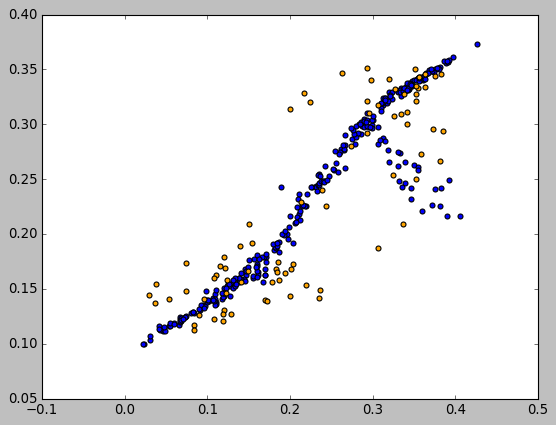

In [169]:
y_pred = model.predict([TS_test,Feat_test])

#plt.scatter(y_train,model.predict(TS_train))
#plt.scatter(y_test,model.predict(TS_test))

#plt.scatter(y_train,model.predict([TS_train,Feat_train]))
#plt.scatter(y_test,model.predict([TS_test,Feat_test]))

y_pred = model.predict([TS_test,Feat_test])
y_pred2 = y_pred
it = 0.0
for i in range(len(y_pred)):
    if np.abs(y_pred[i]) >= 1.0:
        y_pred2[i] = 0.0
        it +=1


plt.scatter(y_train,model.predict([TS_train,Feat_train]),c='blue')
plt.scatter(y_test, y_pred2,c='orange')
print(it)

0.0


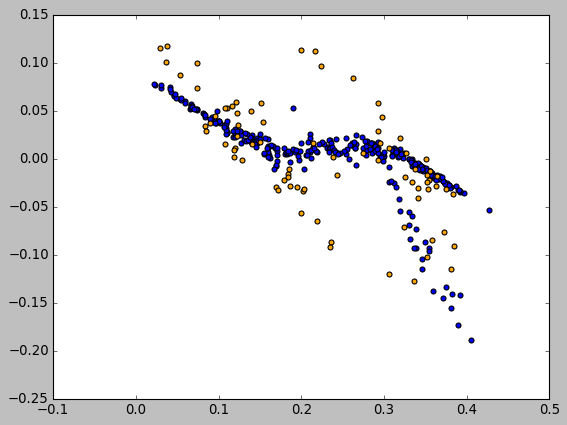

In [170]:
#plt.scatter(y_train,np.ravel(model.predict(TS_train))-y_train)
#plt.scatter(y_test,np.ravel(model.predict(TS_test))-y_test)

#plt.scatter(y_train,np.ravel(model.predict([TS_train,Feat_train]))-y_train)
#plt.scatter(y_test,np.ravel(model.predict([TS_test,Feat_test]))-y_test)

y_pred = model.predict([TS_test,Feat_test])
y_pred2 = y_pred
it = 0.0
for i in range(len(y_pred)):
    if np.abs(y_pred[i]) >= 1.0:
        y_pred2[i] = 0.0
        it +=1

plt.scatter(y_train,np.ravel(model.predict([TS_train,Feat_train]))-y_train, c='blue')
plt.scatter(y_test,np.ravel(y_pred2)-y_test, c='orange')
print(it)

ValueError: x and y must have same first dimension, but have shapes (1500,) and (500,)

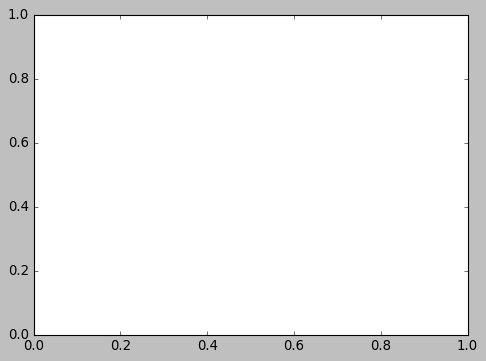

In [166]:
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['mean_absolute_error']
val_acc=hist.history['val_mean_absolute_error']
xc=range(num_epoch)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])